<!--NAVIGATION-->
< [在数组上计算：广播](02.05-Computation-on-arrays-broadcasting.ipynb) | [目录](Index.ipynb) | [高级索引](02.07-Fancy-Indexing.ipynb) >

<a href="https://colab.research.google.com/github/wangyingsm/Python-Data-Science-Handbook/blob/master/notebooks/02.06-Boolean-Arrays-and-Masks.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


# Comparisons, Masks, and Boolean Logic

# 比较，遮盖和布尔逻辑

> This section covers the use of Boolean masks to examine and manipulate values within NumPy arrays.
Masking comes up when you want to extract, modify, count, or otherwise manipulate values in an array based on some criterion: for example, you might wish to count all values greater than a certain value, or perhaps remove all outliers that are above some threshold.
In NumPy, Boolean masking is often the most efficient way to accomplish these types of tasks.

本小节将介绍使用布尔遮盖（掩码）来测试和操作NumPy数组的知识。当我们想通过一些标准对数组中的元素值进行提取、修改、计数或者其他一些操作的时候，我们需要使用遮盖：例如，你需要计算所有大于某个特定值的元素个数，或者删除那些超出阈值的离群值。在NumPy当中，布尔遮盖基本上是实现这类任务的最有效方式。

## Example: Counting Rainy Days

## 例子：计算下雨的天数

> Imagine you have a series of data that represents the amount of precipitation each day for a year in a given city.
For example, here we'll load the daily rainfall statistics for the city of Seattle in 2014, using Pandas (which is covered in more detail in [Chapter 3](03.00-Introduction-to-Pandas.ipynb)):

设想你有一系列数据代表着某个城市一年中每天的降水量。例如，下面我们将使用Pandas读取2014年西雅图的每天降雨统计数据（Pandas我们将在[第三章](03.00-Introduction-to-Pandas.ipynb)详细介绍）：

In [1]:
import numpy as np
import pandas as pd

# 使用Pandas读取降水量以英寸为单位的数据
rainfall = pd.read_csv('data/Seattle2014.csv')['PRCP'].values
inches = rainfall / 254.0  # 0.1毫米转换成英寸
inches.shape

(365,)

> The array contains 365 values, giving daily rainfall in inches from January 1 to December 31, 2014.

这个数组包含着365个元素值，这些值代表着西雅图市2014年从1月1日到12月31日的降雨（单位英寸）。

> As a first quick visualization, let's look at the histogram of rainy days, which was generated using Matplotlib (we will explore this tool more fully in [Chapter 4](04.00-Introduction-To-Matplotlib.ipynb)):

我们使用图表可视化展示一下，用简单的直方图来画出降雨天数的分布情况。这里需要使用到Matplotlib（有关内容我们将在[第四章](04.00-Introduction-To-Matplotlib.ipynb)详细介绍）：

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # 设置图表的风格，seaborn

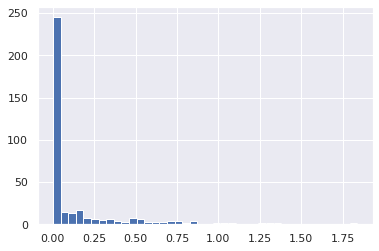

In [3]:
plt.hist(inches, 40); # 将降水量区间40等分作为横轴，将落在区间的元素个数作为纵轴

> This histogram gives us a general idea of what the data looks like: despite its reputation, the vast majority of days in Seattle saw near zero measured rainfall in 2014.
But this doesn't do a good job of conveying some information we'd like to see: for example, how many rainy days were there in the year? What is the average precipitation on those rainy days? How many days were there with more than half an inch of rain?

上面的直方图给我们提供了一个对这个数据集的通用观察结论：虽然名声在外，但事实上西雅图在2014年中绝大部分日子的降雨量都接近于0。但是这张图并没有帮助我们了解一些我们希望得到的数据：例如，一年之中有多少天在下雨？下雨的日子中降水量的平均值是多少？一年之中有多少天降水量超过半英寸？

### Digging into the data

### 挖掘数据

> One approach to this would be to answer these questions by hand: loop through the data, incrementing a counter each time we see values in some desired range.
For reasons discussed throughout this chapter, such an approach is very inefficient, both from the standpoint of time writing code and time computing the result.
We saw in [Computation on NumPy Arrays: Universal Functions](02.03-Computation-on-arrays-ufuncs.ipynb) that NumPy's ufuncs can be used in place of loops to do fast element-wise arithmetic operations on arrays; in the same way, we can use other ufuncs to do element-wise *comparisons* over arrays, and we can then manipulate the results to answer the questions we have.
We'll leave the data aside for right now, and discuss some general tools in NumPy to use *masking* to quickly answer these types of questions.

有一种方法我们已经掌握了：循环遍历数据，然后对每个元素的值进行判断是否处在相应的范围。在前面的小节中，我们已经解释了为什么这种方式是低效的原因，无论从写代码花的时间来看还是从计算结果需要的时间来看。在[使用Numpy计算：通用函数](02.03-Computation-on-arrays-ufuncs.ipynb)小节中，我们学习了NumPy的ufuncs可以用来替代循环进行逐个元素的算术计算；同样的，我们也可以使用其他的ufuncs来对每个元素进行*比较*运算，通过这种方法我们就可以很简单的回答上面问题。我们暂且放下例子的数据，先介绍一些NumPy中用来进行*遮盖*的通用工具，适合这种任务的处理。

## Comparison Operators as ufuncs

## UFuncs的比较运算符

> In [Computation on NumPy Arrays: Universal Functions](02.03-Computation-on-arrays-ufuncs.ipynb) we introduced ufuncs, and focused in particular on arithmetic operators. We saw that using ``+``, ``-``, ``*``, ``/``, and others on arrays leads to element-wise operations.
NumPy also implements comparison operators such as ``<`` (less than) and ``>`` (greater than) as element-wise ufuncs.
The result of these comparison operators is always an array with a Boolean data type.
All six of the standard comparison operations are available:

在[使用Numpy计算：通用函数](02.03-Computation-on-arrays-ufuncs.ipynb)小节中，我们介绍了ufuncs，而且主要集中介绍了算术运算符。我们知道可以使用`+`、`-`、`*`、`/`和其他的运算可以对数组进行逐个元素的运算操作。NumPy同样也实现了比较运算符如`<`（小于）和`>`（大于）的ufuncs。这些比较运算符的结算结果一定是一个布尔类型的数组。全部6种标准的比较运算都是支持的：

In [4]:
x = np.array([1, 2, 3, 4, 5])

In [5]:
x < 3  # less than

array([ True,  True, False, False, False])

In [6]:
x > 3  # greater than

array([False, False, False,  True,  True])

In [7]:
x <= 3  # less than or equal

array([ True,  True,  True, False, False])

In [8]:
x >= 3  # greater than or equal

array([False, False,  True,  True,  True])

In [9]:
x != 3  # not equal

array([ True,  True, False,  True,  True])

In [10]:
x == 3  # equal

array([False, False,  True, False, False])

> It is also possible to do an element-wise comparison of two arrays, and to include compound expressions:

也可以对两个数组的每个元素进行比较，还支持运算的组合操作：

In [11]:
(2 * x) == (x ** 2)

array([False,  True, False, False, False])

> As in the case of arithmetic operators, the comparison operators are implemented as ufuncs in NumPy; for example, when you write ``x < 3``, internally NumPy uses ``np.less(x, 3)``.
    A summary of the comparison operators and their equivalent ufunc is shown here:

就像算术运算符一样，比较运算符实际上也是NumPy的ufuncs的简写方式；例如，当你写`x < 3`的时候，实际上调用的是NumPy的`np.less(x, 3)`。小标列出了比较运算符及其对应的ufuncs：

| 运算符	    | 相应的ufunc    || 运算符	   | 相应的ufunc    |
|---------------|---------------------||---------------|---------------------|
|``==``         |``np.equal``         ||``!=``         |``np.not_equal``     |
|``<``          |``np.less``          ||``<=``         |``np.less_equal``    |
|``>``          |``np.greater``       ||``>=``         |``np.greater_equal`` |

> Just as in the case of arithmetic ufuncs, these will work on arrays of any size and shape.
Here is a two-dimensional example:

如同算术运算ufuncs，比较运算也能应用在任何长度任何形状的数组上。下面是一个二维数组例子：

In [12]:
rng = np.random.RandomState(0)
x = rng.randint(10, size=(3, 4))
x

array([[5, 0, 3, 3],
       [7, 9, 3, 5],
       [2, 4, 7, 6]])

In [13]:
x < 6

array([[ True,  True,  True,  True],
       [False, False,  True,  True],
       [ True,  True, False, False]])

> In each case, the result is a Boolean array, and NumPy provides a number of straightforward patterns for working with these Boolean results.

在任何的情况下，结果都是一个布尔类型数组，NumPy还提供了数量众多的函数能够直接对这些布尔数组进行操作。

## Working with Boolean Arrays

## 操作布尔数组

> Given a Boolean array, there are a host of useful operations you can do.
We'll work with ``x``, the two-dimensional array we created earlier.

对于一个布尔数组，你可以进行许多有用的操作。我们继续使用上面我们创建的二维数组`x`来说明。

In [14]:
print(x)

[[5 0 3 3]
 [7 9 3 5]
 [2 4 7 6]]


### Counting entries

### 计算元素个数

> To count the number of ``True`` entries in a Boolean array, ``np.count_nonzero`` is useful:

要计算一个布尔数组的真值`True`元素的个数，`np.count_nonzero`可以做到：

In [15]:
# 有多少个元素小于6？
np.count_nonzero(x < 6)

8

> We see that there are eight array entries that are less than 6.
Another way to get at this information is to use ``np.sum``; in this case, ``False`` is interpreted as ``0``, and ``True`` is interpreted as ``1``:

我们可以看到数组当中有8个元素的值小于6.另一种可选的方法是使用`np.sum`；因为在Python中，`False`实际上代表0，而`True`实际上代表1：

In [16]:
np.sum(x < 6)

8

> The benefit of ``sum()`` is that like with other NumPy aggregation functions, this summation can be done along rows or columns as well:

使用`sum()`函数的好处是它的使用就像NumPy的聚合函数一样，可以沿着不同的维度进行计算（如行或列）：

In [17]:
# 在每一行中有多少个元素小于6？
np.sum(x < 6, axis=1)

array([4, 2, 2])

> This counts the number of values less than 6 in each row of the matrix.

上例计算了矩阵中每一行中小于6的元素的个数。

> If we're interested in quickly checking whether any or all the values are true, we can use (you guessed it) ``np.any`` or ``np.all``:

如果我们关心的问题是，是否有任何的元素值或全部的元素值为True，我们可以使用`np.any`或`np.all`：

In [18]:
# 有没有任何一个元素大于8？
np.any(x > 8)

True

In [19]:
# 有没有任何元素小于0
np.any(x < 0)

False

In [20]:
# 所有的元素都小于10？
np.all(x < 10)

True

In [21]:
# 所有的元素都等于6？
np.all(x == 6)

False

> ``np.all`` and ``np.any`` can be used along particular axes as well. For example:

`np.all`和`np.any`也可以沿着特定的轴进行运算，例如：

In [22]:
# 是否每一行的所有值都小于8？
np.all(x < 8, axis=1)

array([ True, False,  True])

> Here all the elements in the first and third rows are less than 8, while this is not the case for the second row.

上例结果表明，第一行和第三行所有的元素值都小于8，而第二行却不满足。

> Finally, a quick warning: as mentioned in [Aggregations: Min, Max, and Everything In Between](02.04-Computation-on-arrays-aggregates.ipynb), Python has built-in ``sum()``, ``any()``, and ``all()`` functions. These have a different syntax than the NumPy versions, and in particular will fail or produce unintended results when used on multidimensional arrays. Be sure that you are using ``np.sum()``, ``np.any()``, and ``np.all()`` for these examples!

最后提醒一下：就像在[聚合：Min, Max, 以及其他](02.04-Computation-on-arrays-aggregates.ipynb)中提示过的一样，Python也有內建的`sum()`、`any()`和`all()`函数。它们和NumPy对应的函数有着不同的语法，特别是应用在多维数组进行计算时，会得到错误和无法预料的结果。你需要保证使用NumPy提供的函数来进行相应的运算。

### Boolean operators

### 布尔运算符

> We've already seen how we might count, say, all days with rain less than four inches, or all days with rain greater than two inches.
But what if we want to know about all days with rain less than four inches and greater than one inch?
This is accomplished through Python's *bitwise logic operators*, ``&``, ``|``, ``^``, and ``~``.
Like with the standard arithmetic operators, NumPy overloads these as ufuncs which work element-wise on (usually Boolean) arrays.

我们已经学习到了如何计算雨量小于4英寸的天数或者雨量大于2英寸的天数。但是如果我们期望的结果是雨量小于4英寸并且大于1英寸的天数，该怎么做？这可以通过Python的*位运算符*来实现，包括`&`、`|`、`^`和`~`。就像普通的算术运算符一样，NumPy重载了这些符号作为ufuncs，可以在数组（通常是布尔数组）每个元素值上进行位操作。

> For example, we can address this sort of compound question as follows:

例如，我们可以进行下面这个复合运算操作：

In [23]:
np.sum((inches > 0.5) & (inches < 1))

29

> So we see that there are 29 days with rainfall between 0.5 and 1.0 inches.

从结果我们得出结论，雨量介于0.5和1.0英寸之间的天数是29天。

> Note that the parentheses here are important–because of operator precedence rules, with parentheses removed this expression would be evaluated as follows, which results in an error:

注意上面例子中两个比较运算的括号是必不可少的，因为运算符顺序规定，位运算优于比较运算，因此，如果省略括号，我们会得到下面语句一样的结果，显然是错误的：

``` python
inches > (0.5 & inches) < 1
```

> Using the equivalence of *A AND B* and *NOT (NOT A OR NOT B)* (which you may remember if you've taken an introductory logic course), we can compute the same result in a different manner:

下面的例子使用了一种等同的语法来得到相同的结果，这种写法基于逻辑算术的基本知识：*A 且 B* 和 *非(非A 或 非B)*是相等的：

In [24]:
np.sum(~( (inches <= 0.5) | (inches >= 1) ))

29

> Combining comparison operators and Boolean operators on arrays can lead to a wide range of efficient logical operations.

结合比较运算和布尔运算就可以获得在数组上进行绝大部分逻辑运算的能力。

> The following table summarizes the bitwise Boolean operators and their equivalent ufuncs:

下表列出了布尔运算符及其对应ufuncs：

| 运算符	    | 相应的ufunc    || 运算符	    | 相应的ufunc    |
|---------------|---------------------||---------------|---------------------|
|``&``          |``np.bitwise_and``   ||&#124;      |``np.bitwise_or``    |
|``^``          |``np.bitwise_xor``   ||``~``          |``np.bitwise_not``   |

> Using these tools, we might start to answer the types of questions we have about our weather data.
Here are some examples of results we can compute when combining masking with aggregations:

使用这些工具，我们可以回头来解答前面例子中关于雨量的四个问题。下面的代码就是我们结合遮盖和聚合之后得到的问题的答案：

In [27]:
print("无雨的天数             ：", np.sum(inches == 0))
print("有雨的天数             ：", np.sum(inches != 0))
print("雨量大于0.5英寸的天数   ：", np.sum(inches > 0.5))
print("雨量小于0.2英寸的有雨天数：", np.sum((inches > 0) & (inches < 0.2)))

无雨的天数             ： 215
有雨的天数             ： 150
雨量大于0.5英寸的天数   ： 37
雨量小于0.2英寸的有雨天数： 75


## Boolean Arrays as Masks

## 使用布尔数组作为遮盖

> In the preceding section we looked at aggregates computed directly on Boolean arrays.
A more powerful pattern is to use Boolean arrays as masks, to select particular subsets of the data themselves.
Returning to our ``x`` array from before, suppose we want an array of all values in the array that are less than, say, 5:

在刚才的例子中，我们在布尔数组上应用聚合操作，得到结果。一个更加有用的场景是使用布尔数组作为遮盖，用来从数据集中选择目标数据出来。回到前面数组`x`的例子，如果我们要选择数组中所有小于5的元素，可以这样做：

In [28]:
x

array([[5, 0, 3, 3],
       [7, 9, 3, 5],
       [2, 4, 7, 6]])

> We can obtain a Boolean array for this condition easily, as we've already seen:

使用下面的比较运算很容易得到一个布尔数组，指代每个元素是否小于5：

In [29]:
x < 5

array([[False,  True,  True,  True],
       [False, False,  True, False],
       [ True,  True, False, False]])

> Now to *select* these values from the array, we can simply index on this Boolean array; this is known as a *masking* operation:

下面我们来从数组中*选择*符合条件的值出来，我们可以将上面得到的布尔数组作为索引带入数组中，成为*遮盖*操作：

In [30]:
x[x < 5]

array([0, 3, 3, 3, 2, 4])

> What is returned is a one-dimensional array filled with all the values that meet this condition; in other words, all the values in positions at which the mask array is ``True``.

返回的是一个一维数组，里面的每个元素都满足条件：那就是结果数组中出现的元素对应的是遮盖布尔数组相应位置上为`True`真值。

> We are then free to operate on these values as we wish.
For example, we can compute some relevant statistics on our Seattle rain data:

然后就可以灵活应用遮盖方法来获得我们需要的值了。例如，下面例子计算了很多西雅图雨量数据集相关的统计值：

In [31]:
# 下雨天的遮盖数组
rainy = (inches > 0)

# 夏天的遮盖数组(6月21日是一年的第172天)
days = np.arange(365)
summer = (days > 172) & (days < 262)

print("2014年下雨天雨量中位数（英寸）：", np.median(inches[rainy]))
print("2014年夏天雨量中位数（英寸）：", np.median(inches[summer]))
print("2014年夏天雨量最大值（英寸）：",np.max(inches[summer]))
print("除夏季外其他下雨天雨量中位数（英寸）：", np.median(inches[rainy & ~summer]))

2014年下雨天雨量中位数（英寸）： 0.19488188976377951
2014年夏天雨量中位数（英寸）： 0.0
2014年夏天雨量最大值（英寸）： 0.8503937007874016
除夏季外其他下雨天雨量中位数（英寸）： 0.20078740157480315


> By combining Boolean operations, masking operations, and aggregates, we can very quickly answer these sorts of questions for our dataset.

结合布尔操作、遮盖操作和聚合操作，我们可以很快在数据集中得到这类问题的答案。

## Aside: Using the Keywords and/or Versus the Operators &/|

## 附加内容：对比使用and/or关键字和&/|运算符

> One common point of confusion is the difference between the keywords ``and`` and ``or`` on one hand, and the operators ``&`` and ``|`` on the other hand.
When would you use one versus the other?

使用关键字`and`和`or`，与使用运算符`&`和`|`，两者的区别，常常会困惑很多人。什么情况下你应该用哪种运算呢？

> The difference is this: ``and`` and ``or`` gauge the truth or falsehood of *entire object*, while ``&`` and ``|`` refer to *bits within each object*.

区别在于：`and`和`or`用在将*整个对象*当成真值或假值进行运算的场合，而`&`和`|`会针对*每个对象内的二进制位*进行运算。

> When you use ``and`` or ``or``, it's equivalent to asking Python to treat the object as a single Boolean entity.
In Python, all nonzero integers will evaluate as True. Thus:

当你使用`and`或`or`的时候，相当于要求Python将对象当成是一个布尔值的整体。在Python中，所有的非0值都会被演算成True，因此：

In [32]:
bool(42), bool(0)

(True, False)

In [33]:
bool(42 and 0)

False

In [34]:
bool(42 or 0)

True

> When you use ``&`` and ``|`` on integers, the expression operates on the bits of the element, applying the *and* or the *or* to the individual bits making up the number:

当你在整数上使用`&`和`|`运算时，这两个操作会运算整数中的每个二进制位，在每个二进制位上执行*二进制与*或*二进制或*操作：

In [35]:
bin(42)

'0b101010'

In [36]:
bin(59)

'0b111011'

In [37]:
bin(42 & 59)

'0b101010'

In [38]:
bin(42 | 59)

'0b111011'

> Notice that the corresponding bits of the binary representation are compared in order to yield the result.

对比一下上面例子中的结果是如何从操作数上进行二进制运算获得的。

> When you have an array of Boolean values in NumPy, this can be thought of as a string of bits where ``1 = True`` and ``0 = False``, and the result of ``&`` and ``|`` operates similarly to above:

当数组是一个NumPy的布尔数组时，你可以将这个布尔数组想象成它是由一系列二进制位组成的，因为``1 = True``和``0 = False``，所以使用`&`和`|`运算得到的结果类似上面的例子：

In [39]:
A = np.array([1, 0, 1, 0, 1, 0], dtype=bool)
B = np.array([1, 1, 1, 0, 1, 1], dtype=bool)
A | B

array([ True,  True,  True, False,  True,  True])

> Using ``or`` on these arrays will try to evaluate the truth or falsehood of the entire array object, which is not a well-defined value:

在数组间使用`or`操作时，等同于要求Python把数组当成一个整体来求出最终的真值或假值，这样的值是不存在的，因此会导致一个错误：

In [40]:
A or B

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

> Similarly, when doing a Boolean expression on a given array, you should use ``|`` or ``&`` rather than ``or`` or ``and``:

类似的，当对于给定的数组进行布尔表达式运算时，你应该使用`|`或`&`，而不是`or`或`and`：

In [41]:
x = np.arange(10)
(x > 4) & (x < 8)

array([False, False, False, False, False,  True,  True,  True, False,
       False])

> Trying to evaluate the truth or falsehood of the entire array will give the same ``ValueError`` we saw previously:

同样如果试图把数组当成一个整体计算最终真值或假值也是不被允许的，结果还是我们前面看到的那个`ValueError`：

In [42]:
(x > 4) and (x < 8)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

> So remember this: ``and`` and ``or`` perform a single Boolean evaluation on an entire object, while ``&`` and ``|`` perform multiple Boolean evaluations on the content (the individual bits or bytes) of an object.
For Boolean NumPy arrays, the latter is nearly always the desired operation.

因此，你只需要记住：`and`和`or`对整个对象进行单个布尔操作，而`&`和`|`会对一个对象进行多个布尔操作（比如其中每个二进制位）。对于NumPy布尔数组来说，需要的总是后两者。

<!--NAVIGATION-->
< [在数组上计算：广播](02.05-Computation-on-arrays-broadcasting.ipynb) | [目录](Index.ipynb) | [高级索引](02.07-Fancy-Indexing.ipynb) >

<a href="https://colab.research.google.com/github/wangyingsm/Python-Data-Science-Handbook/blob/master/notebooks/02.06-Boolean-Arrays-and-Masks.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
